# Read .smr files into Python using NEO

<a id='section1'></a>
## ***(1) Load and Check Python packages***


In [1]:
# import os
# os.chdir('/home/shiva/Downloads/python-neo-0.10.0')

!python -m pip install /home/shiva/Downloads/python-neo-0.10.0 ## neo version 10 is not released yet you have to download the release from github


Processing /home/shiva/Downloads/python-neo-0.10.0
  Created wheel for neo: filename=neo-0.10.0-py3-none-any.whl size=548139 sha256=8af2ffc8194d831d8b931010104028e10f86bfd3678abdb8e332c77718c68031
  Stored in directory: /home/shiva/.cache/pip/wheels/be/3b/df/da74cef4339b70ceedf7bb0e9ff1726c8c942adb6a5e90bdac
Successfully built neo
  Attempting uninstall: neo
    Found existing installation: neo 0.10.0
    Uninstalling neo-0.10.0:
      Successfully uninstalled neo-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tridesclous 1.6.3.dev0 requires numba, which is not installed.


In [9]:
# load Python modules
!python -m pip install sonpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import neo
from neo.io import Spike2IO
import sys

import csv
print(neo.__version__)

# plot the output of matplotlib commands in the notebook
%matplotlib inline

0.10.0


In [3]:
# Which version of Python is installed?
print(sys.version)

3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


<a id='section2'></a>
##  (2) Read .smr file with Spike2IO
##### [back to top](#section1)

In [16]:
# import a Spike2 file (CED)
filepath='/home/shiva/Desktop/SquarePulse_k03_D2only_test.smr'
filename = os.path.basename(filepath)
r= neo.Spike2IO(filepath)


## (2) Read .smrx with CedIO (not working)

In [6]:
filepath = '/home/shiva/Desktop/SquarePulse_k03_D2only.smrx'
r = neo.CedIO(filename)

In [7]:
print(' filename = {}:\n'.format(filepath.split('/')[-1]))
bl = r.read()[0] # read the file 
analogsignals = bl.segments[0].analogsignals
print('number of segments = ', len(bl.segments))
print('number of analog signals = ', len(analogsignals))
for i in range(len(analogsignals)):
    print('signal {} contains {} series'.format(i+1, analogsignals[i].shape[1]))
# print('signal type = ', type(asig))

 filename = SquarePulse_k03_D2only.smrx:

number of segments =  1
number of analog signals =  4
signal 1 contains 1 series
signal 2 contains 1 series
signal 3 contains 1 series
signal 4 contains 1 series


The last 3 channels are stacked toghether. The laser epochs are the second column of the second signal.

In [10]:
# keep the signal as a 16 bit float
asig = np.float16(analogsignals[1][:,1])
fs = 1000 # sampling rate
laser_threshold = 4 # 
pts = int(np.prod(asig.shape)) # number of datapoints
secs = pts/fs # recording length in seconds
time = np.linspace(0, secs, pts)
print('{} data points\n{} sec\n'.format(
        pts, secs))

113845 data points
113.845 sec



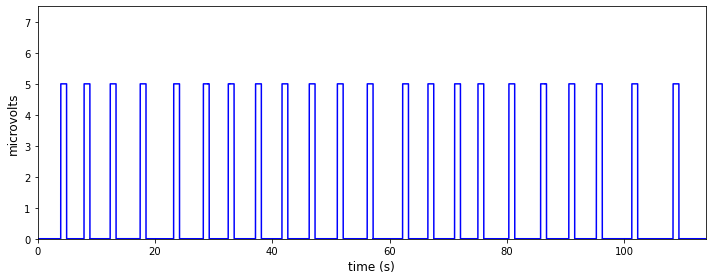

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
miny = np.min(asig) ; maxy = np.max(asig)* 1.5
ax.plot(time , asig, 'b') 
ax.set_xlabel('time (s)', fontsize=12)
ax.set_ylabel('microvolts', fontsize=12)
ax.set_xlim(0, secs)
ax.set_ylim(miny, maxy)
plt.tight_layout()

In [12]:
peaks = (asig > laser_threshold).reshape(1,-1)[0]
peaks = peaks * 1
shifted_right = np.roll(peaks, 1)
shifted_left = np.roll(peaks, -1)

laser_start = np.where(peaks - shifted_right > 0)[0]
laser_end = np.where(peaks - shifted_left > 0)[0]
print('laser starts = \n\n', time[laser_start],
      '\n\n laser ends = \n\n', time[laser_end])

laser starts = 

 [  3.94303464   7.91506952  12.37110867  17.47915353  23.18620366
  28.24224808  32.48728536  37.1363262   41.64636582  46.28840659
  51.07544864  56.17349342  62.20554641  66.51558426  71.06562423
  75.03765912  80.30970543  85.72675301  90.53279523  95.22483644
 101.26788952 108.29295123] 

 laser ends = 

 [  4.94204341   8.9140783   13.37011744  18.47816231  24.18521244
  29.24125685  33.48629414  38.13533498  42.64537459  47.28741537
  52.07445742  57.1725022   63.20455518  67.51459304  72.06463301
  76.0366679   81.30871421  86.72576179  91.531804    96.22384522
 102.2668983  109.29196001]


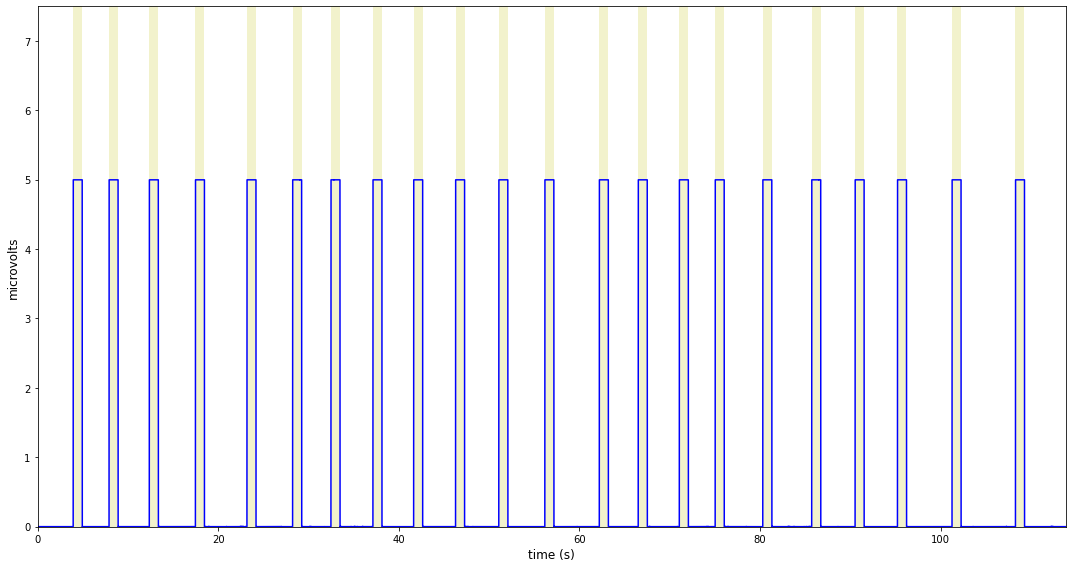

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
miny = np.min(asig) ; maxy = np.max(asig)* 1.5
ax.plot(time , asig, 'b') 
ax.set_xlabel('time (s)', fontsize=12)
ax.set_ylabel('microvolts', fontsize=12)
ax.set_xlim(0, secs)
ax.set_ylim(miny, maxy)
plt.tight_layout()

for (start, end) in zip(laser_start,laser_end):
    plt.axvspan(time[start], time[end],  facecolor='y', alpha=0.2)

# (3) Save laser stampts skipping rows as before

In [33]:

metadatas=[[filepath],
            ["framerate : "],
            ["csv_aligned :", 'NO'],
           ["first_laser_time : ", 'None']
           ]
df = pd.DataFrame(np.concatenate((laser_start.reshape(-1,1), laser_end.reshape(-1,1)),
                                  axis = 1) , 
                  columns = ['ON', 'OFF'])
resultFilePath = filepath.replace(os.path.splitext(filename)[1], '.csv')
with open(resultFilePath, 'w') as resultfile:
             
    csvResult=csv.writer(resultfile,delimiter=',', lineterminator='\n')
    csvResult.writerows(metadatas)

df.to_csv(resultFilePath, mode = 'a',
          index = False)